# Chemical Equilibrium VII

[What is Bond listening to right now?](https://www.youtube.com/watch?v=SCHSLAk801w&list=RDSCHSLAk801w&start_radio=1)

This lecture introduces solutions for multi-reaction equilibria.  These examples will use the same basic principles covered thus far in the Chemical Equilibrium section of the course. The major difference is that we will now be solving multivariate problems comprised of systems of algebraic equations expressed in terms of multiple unknown extents of reaction. This situation will arise anytime we consider chemical equilibria involving more than one reaction. We will still use a numerical equation solver from `scipy.optimize`. Because we are no longer dealing with univariate problems, `opt.newton()` is no longer viable. Now we'll switch to `opt.root()` which is designed to solve multiple nonlinear algebraic equations and is generally our tool of choice for the analysis of multi-reaction equilibria.

A basic overview of `opt.root()` usage is given in [Notebook 03](https://jqbond.github.io/CEN587/Notebooks/587-N03.html) and covered in more detail in [Supplement 12](https://jqbond.github.io/CEN587/Supplements/587-S12.html).

```{note}
Example Problem 01 in this Notebook is Example Problem 3.5 in *Chemical Reactor Analysis and Design Fundamentals, 2nd ed.* by Rawlings and Ekerdt. Example Problems 02 and 03 in this Notebook are modified forms of Example Problem 3.5 in *Chemical Reactor Analysis and Design Fundamentals, 2nd ed.* by Rawlings and Ekerdt.
```

In [1]:
import numpy as np
import scipy.optimize as opt 
import matplotlib.pyplot as plt

## Example Problem 01

The two reactions below represent possible products that can form in the alkylation of isobutane with 1-butene.  This is actually a really important industrial process for converting relatively low-value butane into high octane gasoline additives (triptane, also called isooctane).

\begin{align*}
    (1) \qquad \text{isobutane (g)} + \text{1-butene (g)} &\leftrightarrow \text{2,2,3-trimethylpentane (g)} \\
    (2) \qquad \text{isobutane (g)} + \text{1-butene (g)} &\leftrightarrow \text{2,2,4-trimethylpentane (g)} \\
\end{align*}

It is common in reactor design that we represent reaction systems with generic notation to simplify labelling.  We will represent these reactions more succinctly as:

\begin{align*}
    (1) \qquad \text{A (g)} + \text{B (g)} &\leftrightarrow \text{C (g)} \\ 
    (2) \qquad \text{A (g)} + \text{B (g)} &\leftrightarrow \text{D (g)} \\
\end{align*}

Both reactions are occurring in a batch reactor (closed system) in which temperature is constant at 400K, and pressure is constant at 1875.16 Torr. The system is initially charged with an equimolar quantity of isobutane (A) and 1-butene (B).  Under these conditions, you may assume that all species are in the gas phase, and that all gases behave ideally. The following thermodynamic data is available for the two reactions as written at 1 bar and 400K:

\begin{align*}
    {\Delta G}^\circ_1 &= -3.72 \,\frac{\textrm{kcal}}{\textrm{mol}} \\
    {\Delta G}^\circ_2 &= -4.49 \,\frac{\textrm{kcal}}{\textrm{mol}} \\
\end{align*}

Calculate the equilibrium composition of this mixture.

### Solution to Example Problem 01

We are trying to determine the system composition at chemical equilibrium from thermodynamic data.  As usual, we do this by considering the following relationship:		

$$\exp\left(\frac{-{\Delta G}^\circ_i}{RT}\right) = K_i = \prod_{j = 1}^{N_S}a_j^{\nu_{i,j}}$$

You'll notice a very slight modification to this in that I've added an index, $i$, which corresponds to the reaction number (here, 1 or 2).  We developed this equation in consideration of a single reaction.  When we have multiple reactions, this equation will apply to each and every reaction independently.  So we basically end up writing a copy of that equation for every reaction that is happening in our system. With that in mind, to determine the equilibrium composition of the mixture, we need to solve the following two equations simultaneously:

\begin{align*}
    \exp\left(\frac{-{\Delta G}^\circ_1}{RT}\right) &= K_1 = \frac{a_C}{a_A a_B}\\
    \\
    \exp\left(\frac{-{\Delta G}^\circ_2}{RT}\right) &= K_2 = \frac{a_D}{a_A a_B}\\
\end{align*}

#### Calculating thermodynamic equilibrium constants

First, let's figure out the values of our equilibrium constants.  These need to be calculated from the standard state Gibbs free energy.  Since this is a gas phase reaction, we define these at:

1. $T^\circ$ = Reaction Temperature (Here, 400K)
2. $P^\circ = 1$ bar 
3. Pure species $j$ as a gas

If we look at the Gibbs free energy data given above, values are given at exactly these conditions, so we can calculate the appropriate equilibrium constants directly using:

$$K_i = \exp\left(\frac{-{\Delta G}^\circ_i}{RT}\right)$$

This is encoded in the cell below.

In [2]:
#############################################################################
# Globals                                                                   #
#############################################################################

#Gibbs free energies at P0 = 1 bar and T0 = 400K
ΔG10 = -3.72      #kcal/mol
ΔG20 = -4.49      #kcal/mol

#Gas constant in relevant units
R    = 1.987e-3   #kcal/mol/K

#Reference temperature and pressure for thermodynamic data (400K)
T0   = 400        #K
P0   = 1          #bar

#Reaction Pressure, it is the same in all of these examples
PRXN = 1875.16    #Torr
P    = PRXN/750   #convert to bar

#Calculate equilibrium constants at T = 400K, P = 1 bar, gas phase species
K10  = np.exp(-ΔG10/R/T0)
K20  = np.exp(-ΔG20/R/T0)

print(f'A T = {T0:0.0f}K, K1 = {K10:4.1f} and K2 = {K20:4.1f}')

A T = 400K, K1 = 107.8 and K2 = 284.1


#### Now we work on the composition and pressure dependencies...

Now that we know the values of the equilibrium constants, we now have to fill out the right hand side of these equations, i.e.:

\begin{align*}
    K_1 &= \frac{a_C}{a_A a_B}\\
    \\
    K_2 &= \frac{a_D}{a_A a_B}\\
\end{align*}

We do this exactly the same way as first illustrated in [Notebook 06](https://jqbond.github.io/CEN587/Notebooks/587-N06.html) and further applied in all of the Notebooks covering Ammonia synthesis (Notebooks 07 - 10).  As usual, activities are defined as:

$$a_j = \frac{\hat{f}_j}{f_j^\circ}$$

Remember: activities are ***species specific***, so it doesn't matter that we have many reactions, we always define activities this way. The numerator is the fugacity of species $j$ under reaction conditions $(T = 400K, \ P = 1875.16 \ \mathrm{Torr}, x_j = ?)$. The denominator is the fugacity of species $j$ in its reference state. Our reference state for gas-phase species is a pure species at 1 bar and the reaction temperature $(T = 400K)$. Our convention for calculating fugacities of gases in a mixture uses the Lewis Randall rule.  With these things in mind, formally, we have:

$$a_j = \frac{y_j \phi_j P}{y_j^\circ \phi_j^\circ  P^\circ}$$

Looking at the numerator, we are operating this reactor at 1875.16 Torr.  This is about 2.5 bar, so it is at least somewhat reasonable to say that the fugacity coefficient for species $j$ under reaction conditions, $\phi_j \approx 1$. Looking at the denominator, the reference state is a pure species, so $y_j^\circ = 1$.  Further, that pure species is at 1 bar, so $\phi_j^\circ = 1$. This gives the usual result for low pressure gases:

$$a_j = \frac{y_j P}{P^\circ}$$

Now we apply this equation to all of the species participating in the reaction.  Notice that I'm still retaining $P$ and $P^\circ$ in my solution.  This helps me to keep it general, and to make sure that I take care to be dimensionally consistent. If we substitute these activity definitions into our two equations that we're trying to solve, we find:

\begin{align*}
    K_1 = \frac{\left(\frac{y_C P}{P^\circ}\right)}{\left(\frac{y_A P}{P^\circ}\right) \left(\frac{y_B P}{P^\circ}\right)}\\
    \\
    K_2 = \frac{\left(\frac{y_D P}{P^\circ}\right)}{\left(\frac{y_A P}{P^\circ}\right) \left(\frac{y_B P}{P^\circ}\right)}\\
\end{align*}

In other words, there are 2 equations and 4 unknowns here ($y_A$, $y_B$, $y_C$, $y_D$).  To solve this, we now express each mole fraction in terms of the number of moles of species as usual:

$$y_j = \frac{N_j}{\sum N_j}$$

We express each of the molar quantities as functions of extents; in general, we can describe the molar quantity of each species, $N_j$ as a function of all reaction extents:

$$N_j = N_{j,0} + \sum_{i=1}^{N_R} \nu_{i,j} \, \varepsilon_i$$

It is useful to organize this information in a mole table:

|Species |In       |Change                               |End                                        |
|:-------|:-------:|:-----------------------------------:|:-----------------------------------------:|
| $A$    |$N_{A0}$ |$- 1\varepsilon_1 - 1\varepsilon_2$  |$N_{A0} - 1\varepsilon_1 - 1\varepsilon_2$ | 
| $B$    |$N_{B0}$ |$- 1\varepsilon_1 - 1\varepsilon_2$  |$N_{B0} - 1\varepsilon_1 - 1\varepsilon_2$ |
| $C$    |$N_{C0}$ |$+ 1\varepsilon_1 + 0\varepsilon_2$  |$N_{C0} + 1\varepsilon_1 + 0\varepsilon_2$ |
| $D$    |$N_{D0}$ |$+ 0\varepsilon_1 + 1\varepsilon_2$  |$N_{D0} + 0\varepsilon_1 + 1\varepsilon_2$ |
| Total  |$N_{T0}$ |$- 1\varepsilon_1 - 1\varepsilon_2$  |$N_{T0} - 1\varepsilon_1 - 1\varepsilon_2$ |


Now that each of these molar quantities are defined as functions of $\varepsilon_1$ and $\varepsilon_2$, it is just a matter of substituting those into mole fractions, then into activities, then into the equilibrium equations...that gives us two equations:

\begin{align*}
    K_1 &= \frac{a_C}{a_A a_B}\\
    \\
    K_2 &= \frac{a_D}{a_A a_B}\\
\end{align*}

If we look carefully at the activity definitions, we should see that these two equations are fully described in terms of only two unknown quantities: $\varepsilon_1$ and $\varepsilon_2$.  We can solve this problem using any nonlinear equation solver we like.  Below, we do this by writing an objective function in Python and solving it with `scipy.opimize.root()`, which is aliased here as `opt.root()`.

```{note}
The only thing left to mention: The problem states that the feed to the reactor is an equimolar quantity of A and B, so we'll set a basis of 1 mole of each species.
```

In [3]:
###########################################################################
# More globals....                                                        #
###########################################################################

#Basis for this system; need to have 1:1 ratio of A:B at reaction start.
NA0 = 1          #mole
NB0 = 1          #mole
NC0 = 0          #moles
ND0 = 0          #moles

In [4]:
###########################################################################
# Define the objective function (i.e., system of equations) to be solved  #
###########################################################################

def P1(var):
    
    ε1 = var[0]
    ε2 = var[1]
     
    NA  = NA0 - ε1 - ε2
    NB  = NB0 - ε1 - ε2
    NC  = NC0 + ε1
    ND  = ND0      + ε2
    
    NT  = NA + NB + NC + ND
    
    yA  = NA/NT
    yB  = NB/NT
    yC  = NC/NT
    yD  = ND/NT

    aA  = yA*P/P0
    aB  = yB*P/P0
    aC  = yC*P/P0
    aD  = yD*P/P0
    
    K1A = aC/aA/aB
    K2A = aD/aA/aB
    
    LHS1 = K10 - K1A
    LHS2 = K20 - K2A
    
    return [LHS1, LHS2]

In [5]:
####################################################
# Solve the system of equations                    #
####################################################
 
var0 = np.array([0.2, 0.6]) #Reasonable initial guesses for ɛ₁ ɛ₂ 
ans  = opt.root(P1, var0)
ans

 message: The solution converged.
 success: True
  status: 1
     fun: [-4.263e-12 -4.093e-12]
       x: [ 2.663e-01  7.017e-01]
  method: hybr
    nfev: 40
    fjac: [[-1.115e-01  9.938e-01]
           [-9.938e-01 -1.115e-01]]
       r: [-1.047e+04 -1.051e+04 -9.500e+02]
     qtf: [ 6.795e-09 -9.893e-09]

In [6]:
######################################################################################
# Solving the system of equations gets us the two extents of reaction at equilibrium #
# We need to do a few more calculations to get composition                           #
# Essentially, the code below plugs the "answers" back into our mole table           #
# This gives us extensive molar quantities of each species                           #
# With these in hand, we can calculate mole fractions of each species                #
######################################################################################

ε1, ε2  = ans.x

NA  = NA0 - ε1 - ε2
NB  = NB0 - ε1 - ε2
NC  = NC0 + ε1
ND  = ND0      + ε2

NT  = NA + NB + NC + ND

yA  = NA/NT
yB  = NB/NT
yC  = NC/NT
yD  = ND/NT

print(f'The mole fractions of A, B, C, and D are {yA:0.3f}, {yB:0.3f}, {yC:0.3f}, and {yD:0.3f}')

The mole fractions of A, B, C, and D are 0.031, 0.031, 0.258, and 0.680


## Example Problem 02

Calculate the equilbrium composition for the system in **Example Problem 01** at $P = 1875.16$ Torr and $T = 327^\circ C \ (T = 600K)$; the following information will be useful. All data reported here were obtained for pure gases at $P = 1 \mathrm{bar}$ and $T = 400K$.

\begin{align*}
    \Delta H^\circ_1  &= -20.1 \,\frac{\textrm{kcal}}{\textrm{mol}}\\
    \Delta H^\circ_2  &= -21.0 \,\frac{\textrm{kcal}}{\textrm{mol}}\\
    \Delta Cp^\circ_1 &= 8.20 \times 10^{-4} \,\frac{\textrm{kcal}}{\textrm{mol K}}\\
    \Delta Cp^\circ_2 &= 1.48 \times 10^{-3} \,\frac{\textrm{kcal}}{\textrm{mol K}} \\
\end{align*}

These are thermodynamic data obtained at a single condition; they are not going to change with various problem statements, so we'll go ahead and add them to the workspace as globals.

In [7]:
################################################################
# Add the new globals, heats of reaction and ΔCp               #
################################################################

ΔH1  = -20.1      #kcal/mol
ΔH2  = -21.0      #kcal/mol
ΔCP1 =  8.20e-4   #kcal/mol/K
ΔCP2 =  1.48e-3    #kcal/mol/K
R    =  1.987e-3   #kcal/mol/K
TR   =  400        #K Technically, ref temperature for ΔH can be different from T0, the ref. temp. for K0.

### Solution to Example Problem 02

We've made one small change to the problem:  The reaction temperature.  We know that this will impact the equilibrium constant for both reactions, but it is not yet clear how.  We are not given properties of individual species; however, we are given standard state changes of enthalpy and heat capacity for both reactions.  This is all we need to figure out how each $K$ will change with reaction temperature.

#### The van't Hoff Equation

We don't have species enthalpies, entropies, and heat capacities like we had in the ammonia synthesis problem.  Instead, we're given heats of reaction and $\Delta C_p$ values for each reaction.  In this case, we'll use the van't Hoff equation, which is a differential equation that describes how an equilibrium constant will change as a function of temperature:

$$\frac{d \ln{K}}{dT} = \frac{\Delta H}{RT^2}$$

This is a separable ODE:

$$d \ln{K} = \frac{\Delta H}{RT^2}dT$$

We integrate both sides:

$$\int_{\ln{K_0}}^{\ln{K}}d \ln{K} = \int_{T_0}^T\frac{\Delta H}{RT^2}dT$$

The left hand side is easy:

$$\int_{\ln{K_0}}^{\ln{K}}d \ln{K} = \ln\left(\frac{K}{K_0}\right)$$

The right hand side of the differential equation requires a bit of work:

$$\int_{T_0}^T\frac{\Delta H(T)}{RT^2}dT$$

Specifically, the heat of reaction, $\Delta H$, is usually a function of temperature, so we can't integrate with respect to temperature until we explicitly specify how $\Delta H$ changes with Temperature.  We do this by recalling that, if we know the $\Delta C_p$ for a reaction, then we can determine the enthalpy change of reaction at any temperature, $T$, as long as we know the heat of reaction at a reference temperature, $H_R$ at $T_R$. Specifically:

$$\Delta H(T) = \Delta H_R + \int_{T_R}^T \Delta C_p dT$$

This can get messy for complex heat capacity expressions, but in our case, both of the $\Delta C_p$ terms are constants, so, in this case:

$$\Delta H(T) = \Delta H_R + \Delta C_p (T - T_R)$$

That gets substituted back into the right hand side of the van't Hoff equation:

$$\int_{T_0}^T\frac{\Delta H(T)}{RT^2}dT = \int_{T_0}^T\frac{\Delta H_R + \Delta C_p (T - T_R)}{RT^2}dT$$

The result of that integral is:

$$\int_{T_0}^T\frac{\Delta H_R + \Delta C_p (T - T_R)}{RT^2}dT = \frac{-(\Delta H_R - \Delta C_p T_R)}{R} \left(\frac{1}{T} - \frac{1}{T_0}\right) + \frac{\Delta C_p}{R} \ln\left(\frac{T}{T_0}\right)$$

Therefore:

$$\ln\left(\frac{K}{K_0}\right) = \frac{-(\Delta H_R - \Delta C_p T_R)}{R} \left(\frac{1}{T} - \frac{1}{T_0}\right) + \frac{\Delta C_p}{R} \ln\left(\frac{T}{T_0}\right)$$

Or, more convenient:

$$K = K_0\exp\left[\frac{-(\Delta H_R - \Delta C_p T_R)}{R} \left(\frac{1}{T} - \frac{1}{T_0}\right) + \frac{\Delta C_p}{R} \ln\left(\frac{T}{T_0}\right)\right]$$

Note that "$K$" is a function of temperature as we've written this.  In other words, once we plug a temperature in on the right hand side, we get the value of the equilibrium constant at that temperature. Frequently, in this course, we'll have problems where $\Delta C_p \approx 0$.  In those cases, the integrated form of the van't Hoff equation is much simpler:

$$K = K_0\exp\left[\frac{-\Delta H_R}{R} \left(\frac{1}{T} - \frac{1}{T_0}\right)\right]$$

```{tip}
Consider what we are equipped with -- a function that calculates the equilibrium constant at any temperature.  This is exactly what we need to finish this problem!!!!
```

In the plot below, we see how the equilibrium constants for both reactions change with temperature.

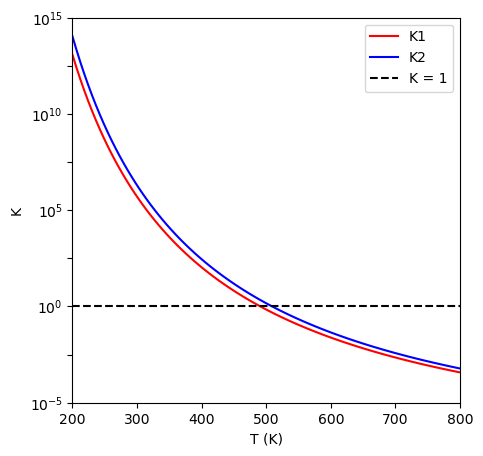

In [8]:
#######################################################################################
# This cell defines functions for K1(T) and K2(T) and then graph their behavior       #
#######################################################################################

#The integrated form of the van't Hoff equation defined using lambda functions
K1 = lambda T: K10*np.exp(-(ΔH1 - ΔCP1*TR)/R*(1/T - 1/T0) + ΔCP1/R*np.log(T/T0))
K2 = lambda T: K20*np.exp(-(ΔH2 - ΔCP2*TR)/R*(1/T - 1/T0) + ΔCP2/R*np.log(T/T0))

TSET = np.linspace(200, 800, 100) #K

plt.figure(figsize = (5,5))
plt.plot(TSET, K1(TSET), color = 'red', label = 'K1')
plt.plot(TSET, K2(TSET), color = 'blue', label = 'K2')
plt.hlines(1, 200, 800, color = 'black', linestyle = 'dashed', label = 'K = 1')
plt.yscale('log')
plt.ylabel('K')
plt.ylim(10**-5, 10**15)
plt.yticks(10**np.linspace(-5, 15, 9))
plt.xlabel('T (K)')
plt.xlim(TSET[0], TSET[-1])
plt.legend()
plt.show()

In [9]:
##################################################################
# We can now easily calculate K1 and K2 at 600K                  #
##################################################################

print(f'At 600K, K1 = {K1(600):0.2E} and K2 = {K2(600):0.2E}')

At 600K, K1 = 2.42E-02 and K2 = 4.49E-02


### Temperature Effects on Reaction Equilibrium

We can similarly adapt our objective function so that it accounts for temperature effects. We will do this by leveraging the `K1(T)` and `K2(T)` lambda functions that we created in the cells above.

In [10]:
############################################################################
# Define a new objective function/system of equations for 600K             #
############################################################################

def P2(var):
    
    ε1 = var[0]
    ε2 = var[1]
    
    T   = 600        #K, actual reaction temperature
    
    NA  = NA0 - ε1 - ε2
    NB  = NB0 - ε1 - ε2
    NC  = NC0 + ε1
    ND  = ND0      + ε2
    
    NT  = NA + NB + NC + ND
    
    yA  = NA/NT
    yB  = NB/NT
    yC  = NC/NT
    yD  = ND/NT

    aA  = yA*P/P0
    aB  = yB*P/P0
    aC  = yC*P/P0
    aD  = yD*P/P0
    
    K1A = aC/aA/aB
    K2A = aD/aA/aB

    #The integrated form of the van't Hoff equation
    K1THERMO = K1(T)
    K2THERMO = K2(T)

    LHS1 = K1THERMO - K1A
    LHS2 = K2THERMO - K2A
    
    return [LHS1, LHS2]

After this, it is basically the same as in Example Problem 01.  All we really did was change the numerical value of $K_1$ and $K_2$ from thermo...otherwise, it is identical to the prior solution, we just make it easy to solve the equilibrium problem at any temperature here.

In [11]:
########################################################
# Solve the system of equations                        #
########################################################

var0 = np.array([0.2, 0.6]) #Reasonable initial guesses for ɛ₁ ɛ₂
ans  = opt.root(P2, var0)
ans

 message: The solution converged.
 success: True
  status: 1
     fun: [ 4.254e-15 -8.216e-15]
       x: [ 2.687e-02  4.972e-02]
  method: hybr
    nfev: 21
    fjac: [[-9.968e-01 -8.053e-02]
           [ 8.053e-02 -9.968e-01]]
       r: [ 9.440e-01  1.199e-01  9.660e-01]
     qtf: [-5.838e-13 -2.418e-12]

In [12]:
######################################################################################
# Solving the system of equations gets us the two extents of reaction at equilibrium #
# We need to do a few more calculations to get composition                           #
# Essentially, the code below plugs the "answers" back into our mole table           #
# This gives us extensive molar quantities of each species                           #
# With these in hand, we can calculate mole fractions of each species                #
######################################################################################

ε1, ε2  = ans.x

NA  = NA0 - ε1 - ε2
NB  = NB0 - ε1 - ε2
NC  = NC0 + ε1
ND  = ND0      + ε2

NT  = NA + NB + NC + ND

yA  = NA/NT
yB  = NB/NT
yC  = NC/NT
yD  = ND/NT

print(f'The mole fractions of A, B, C, and D are {yA:0.3f}, {yB:0.3f}, {yC:0.3f}, and {yD:0.3f}')

The mole fractions of A, B, C, and D are 0.480, 0.480, 0.014, and 0.026


## Example 03

Both of the reactions in Example 01 are occurring in a system that is held at a constant pressure of $P = 1875.16 \ \mathrm{Torr} \ (P = 2.5 \ \mathrm{bar})$. The system is initially charged with an equimolar quantity of isobutane (A) and 1-butene (B). Under these conditions, you may assume that all species are in the gas phase, and that all gases behave ideally. For kinetic reasons, it is desirable to run the reaction at as high a temperature as possible, but this might prevent a high conversion since the reactions are both exothermic. What is the maximum temperature that the reactor can operate and still achieve an isobutane conversion of 70\%?

### Modifying the problem -- temperature is an unknown!

We ultimately need to solve these equations, where $K_i$ is a function of temperature and activities are a function of composition and pressure:

\begin{align*}
    (1) \qquad K_1(T) &= \frac{a_C}{a_A a_B} \\
    \\
    (2) \qquad K_2(T) &= \frac{a_D}{a_A a_B} \\
\end{align*}

Activities are defined as usual:

$$a_j = \frac{\hat{f}_j}{f_j^\circ}$$

For this system, which is at relatively low pressure (and for a reference state of pure species at $T = T_{rxn}$ and $P = 1 \ \mathrm{bar}$), this reduces to:

$$a_j = \frac{y_j P}{P^\circ}$$

We define each mole fraction in terms of numbers of moles:

$$y_j = \frac{N_j}{\sum N_j}$$

We express each of the molar quantities as functions of extents:

|Species |In       |Change                               |End                                        |
|:-------|:-------:|:-----------------------------------:|:-----------------------------------------:|
| $A$    |$N_{A0}$ |$- 1\varepsilon_1 - 1\varepsilon_2$  |$N_{A0} - 1\varepsilon_1 - 1\varepsilon_2$ | 
| $B$    |$N_{B0}$ |$- 1\varepsilon_1 - 1\varepsilon_2$  |$N_{B0} - 1\varepsilon_1 - 1\varepsilon_2$ |
| $C$    |$N_{C0}$ |$+ 1\varepsilon_1 + 0\varepsilon_2$  |$N_{C0} + 1\varepsilon_1 + 0\varepsilon_2$ |
| $D$    |$N_{D0}$ |$+ 0\varepsilon_1 + 1\varepsilon_2$  |$N_{D0} + 0\varepsilon_1 + 1\varepsilon_2$ |
| Total  |$N_{T0}$ |$- 1\varepsilon_1 - 1\varepsilon_2$  |$N_{T0} - 1\varepsilon_1 - 1\varepsilon_2$ |


And we substitute those definitions of mole numbers back into the activity equations.  Ultimately, this ensures that the right hand side of these two equations are only a function of $\varepsilon_1$ and $\varepsilon_2$ (once we specify that P = 2.5 bar):

\begin{align*}
    (1) \qquad K_1(T) &= \frac{a_C}{a_A a_B} \\
    \\
    (2) \qquad K_2(T) &= \frac{a_D}{a_A a_B} \\
\end{align*}

We have assigned a basis of:

\begin{align*}
    N_{A0} = N_{B0} = 1.0 \\
    N_{C0} = N_{D0} = 0.0 \\
\end{align*}

But, we can't solve the problem yet.  All of the mole numbers are quantified in terms of the basis and two extents of reaction, but we don't know the value of either equilibrium constant because we have not set a reaction temperature. This is 2 equations and 4 unknowns.

We solve this problem by realizing that, technically, since we've written van't Hoff relations:

$$K_1(T) = K_{1_0}\exp\left[\frac{-(\Delta H_{1_R} - \Delta C_{p_1} T_R)}{R} \left(\frac{1}{T} - \frac{1}{T_0}\right) + \frac{\Delta C_{p_1}}{R} \ln\left(\frac{T}{T_0}\right)\right]$$

$$K_2(T) = K_{2_0}\exp\left[\frac{-(\Delta H_{2_R} - \Delta C_{p_2} T_R)}{R} \left(\frac{1}{T} - \frac{1}{T_0}\right) + \frac{\Delta C_{p_2}}{R} \ln\left(\frac{T}{T_0}\right)\right]$$

We don't have two unknown equilibrium constants --- we have one unknown temperature.  Once that is specified, we can calculate the value of both equilibrium constants. Still...we have 2 algebraic equations that we're trying to solve:

\begin{align*}
    (1) \qquad 0 &= K_1 - \frac{a_C}{a_A a_B} \\
    \\
    (2) \qquad 0 &= K_2 - \frac{a_D}{a_A a_B} \\
\end{align*}

But we currently have 3 unknowns: $\varepsilon_1$, $\varepsilon_2$, and $T$. We need one more equation to add to our objective function. We get that from our process specification that the fractional conversion of A must be equal to 70%. Based on that, I can write the following---my third and final equation in my objective function:

$$X_A = \frac{N_{A0} - N_A}{N_{A0}} = 0.7$$

With that, we are trying to solve the following 3 equations simultaneously for the the value of the three unknowns ($\varepsilon_1$, $\varepsilon_2$, and $T$):

\begin{align*}
    (1) \qquad 0 &= K_1 - \frac{a_C}{a_A a_B} \\
    \\
    (2) \qquad 0 &= K_2 - \frac{a_D}{a_A a_B} \\
    \\
    (3) \qquad 0 &= \frac{N_{A0} - N_A}{N_{A0}} - 0.7\\ 
\end{align*}

Before proceeding, work through the equations that came before and convince yourself that every single thing in those three equations is defined in terms of constants and our three unknowns ($\varepsilon_1$, $\varepsilon_2$, and $T$). If that is true, then we can totally set this up as a system of equations and solve with `scipy.opimize.root()`!

In [13]:
######################################################################################
# System of equations for finding the temperature where equilibrium conversion = 70% #
######################################################################################

def P3(var):
    
    ε1 = var[0]
    ε2 = var[1]
    T  = var[2]
    
    NA  = NA0 - ε1 - ε2
    NB  = NB0 - ε1 - ε2
    NC  = NC0 + ε1
    ND  = ND0      + ε2
    
    NT  = NA + NB + NC + ND
    
    yA  = NA/NT
    yB  = NB/NT
    yC  = NC/NT
    yD  = ND/NT

    aA  = yA*P/P0
    aB  = yB*P/P0
    aC  = yC*P/P0
    aD  = yD*P/P0
    
    K1A = aC/aA/aB
    K2A = aD/aA/aB

    #The integrated form of the van't Hoff equation
    K1THERMO = K1(T)
    K2THERMO = K2(T)

    XA = (NA0 - NA)/NA0

    LHS1 = K1THERMO - K1A
    LHS2 = K2THERMO - K2A
    LHS3 = XA - 0.7
    
    return [LHS1, LHS2, LHS3]

In [14]:
############################################
# Solving the system of equations          #
############################################

var0 = [0.2, 0.6, 450] # We have 3 unknowns so need 3 initial guesses for ɛ₁, ɛ₂, and T
ans  = opt.root(P3, var0)
ans

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.334e-13 -6.604e-13  1.110e-16]
       x: [ 2.207e-01  4.793e-01  4.853e+02]
  method: hybr
    nfev: 19
    fjac: [[-4.406e-01 -8.976e-01  1.440e-02]
           [ 8.972e-01 -4.408e-01 -2.478e-02]
           [-2.859e-02 -2.004e-03 -9.996e-01]]
       r: [ 6.944e+01  9.134e+01  5.421e-02  1.273e+01 -1.546e-02
            1.164e-03]
     qtf: [-3.629e-08 -9.416e-09 -2.894e-10]

In [15]:
######################################################################################
# Solving the system of equations gets us the two extents of reaction at equilibrium #
# We need to do a few more calculations to get composition                           #
# Essentially, the code below plugs the "answers" back into our mole table           #
# This gives us extensive molar quantities of each species                           #
# With these in hand, we can calculate mole fractions of each species                #
######################################################################################

ε1, ε2, T  = ans.x

NA  = NA0 - ε1 - ε2
NB  = NB0 - ε1 - ε2
NC  = NC0 + ε1
ND  = ND0      + ε2

NT  = NA + NB + NC + ND

yA  = NA/NT
yB  = NB/NT
yC  = NC/NT
yD  = ND/NT
XA  = (NA0 - NA)/NA0

print(f'At T = {T:6.2f} K and P = {PRXN:6.2f} bar, the equilibrium conversion of A is XA = {XA:4.2f}')
print(f'The mole fractions of A, B, C, and D are {yA:0.3f}, {yB:0.3f}, {yC:0.3f}, and {yD:0.3f}')
print(f'At P = {PRXN:0.2f} Torr, this requires an operating temperature of T = {T:6.2f}K')

At T = 485.29 K and P = 1875.16 bar, the equilibrium conversion of A is XA = 0.70
The mole fractions of A, B, C, and D are 0.231, 0.231, 0.170, and 0.369
At P = 1875.16 Torr, this requires an operating temperature of T = 485.29K
